# Problem set 2 (35 + 55 + 15 + 28 = 133 pts)

## Problem 1 (LU decomposition) 35 pts


### 1. LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.$$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

In [1]:
# Your solution is here

In [2]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.
def band3_lu(diag_broadcast, n):
    # enter your code here
    
    ld, md, ud = map(lambda x: np.ones(x[0]) * x[1], zip([n - 1, n, n - 1], diag_broadcast))
    l = np.zeros(n - 1)

    for j in range(n - 1):
        assert md[j] != 0, 'Encountered pivot is zero, choose another matrix'

        md[j + 1] -= (ud[j] / md[j]) * ld[j]
        l[j] = ld[j] / md[j]

    return [l, np.ones(n)], [md, ud]
    
def band5_lu(diag_broadcast, n):
    # enter your code here
    
    ldo, ldi, md, udi, udo = map(lambda x: np.ones(x[0]) * x[1], zip([n-2, n-1, n, n-1, n-2], diag_broadcast))
    lo, li = map(np.zeros, [n - 2, n - 1])

    for j in range(n - 2):
        assert md[j] != 0, 'Encountered pivot is zero, choose another matrix'

        md[j + 1] -= (udi[j] / md[j]) * ldi[j]
        udi[j + 1] -= (udo[j] / md[j]) * ldi[j]

        ldi[j + 1] -= (udi[j] / md[j]) * ldo[j]
        md[j + 2] -= (udo[j] / md[j]) * ldo[j]

        li[j] = ldi[j] / md[j]
        lo[j] = ldo[j] / md[j]

    md[n - 1] -= (udi[n - 2] / md[n - 2]) * ldi[n - 2]
    li[n - 2] = ldi[n - 2] / md[n - 2]

    return [lo, li, np.ones(n)], [md, udi, udo]

In [3]:
n = 7

# diag_broadcast = [1, -2, 1]
# l, u = band3_lu(diag_broadcast, n)
# diags(l, [-1, 0]).toarray() @ diags(u, [0, 1]).toarray()

diag_broadcast = [-3, 1, -2, 1, -3]
l, u = band5_lu(diag_broadcast, n)
diags(l, [-2, -1, 0]).toarray() @ diags(u, [0, 1, 2]).toarray()

array([[-2.,  1., -3.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1., -3.,  0.,  0.,  0.],
       [-3.,  1., -2.,  1., -3.,  0.,  0.],
       [ 0., -3.,  1., -2.,  1., -3.,  0.],
       [ 0.,  0., -3.,  1., -2.,  1., -3.],
       [ 0.,  0.,  0., -3.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0., -3.,  1., -2.]])

In [4]:
import itertools
from tqdm.notebook import tqdm
from scipy.linalg import lu_factor


band3, scipy3 = [], []

diag_broadcast = [-3, 1, -2, 1, -3]
ranges = [np.linspace(2 * mult, 10 * mult, 5, dtype=int) for mult in np.logspace(0, 2, 3)]

for n in tqdm(list(itertools.chain(*ranges))):
    A = diags(list(map(lambda x: [x[0]] * x[1], zip(diag_broadcast, [n-2, n-1, n, n-1, n-2]))), 
              [-2, -1, 0, 1, 2]).toarray()

    t = %timeit -o -q band3_lu(diag_broadcast, n)
    band3.append(t.average)
    
    t = %timeit -o -q lu_factor(A)
    scipy3.append(t.average)

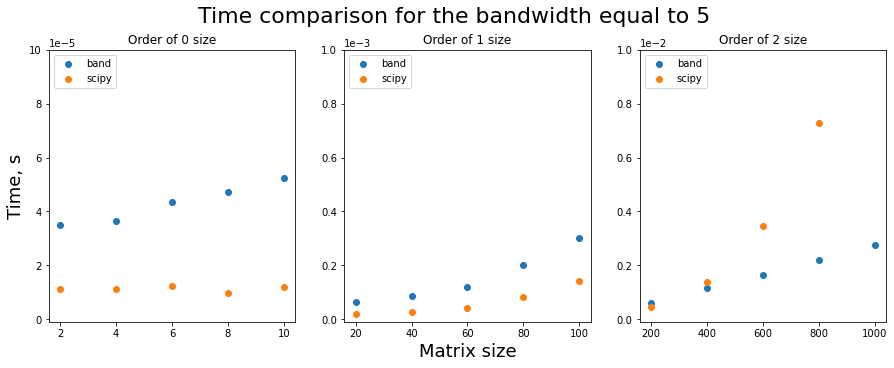

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

fig.suptitle('Time comparison for the bandwidth equal to 5', fontsize=22, y=1)

ax[0].scatter(ranges[0], band3[:5], label='band')
ax[0].scatter(ranges[0], scipy3[:5], label='scipy')
ax[0].set_ylim(-1e-6, 1e-4)
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_title('Order of 0 size')
ax[0].legend(loc=2)

ax[0].set_ylabel('Time, s', fontsize=18)

ax[1].scatter(ranges[1], band3[5:10], label='band')
ax[1].scatter(ranges[1], scipy3[5:10], label='scipy')
ax[1].set_ylim(-1e-5, 1e-3)
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].set_title('Order of 1 size')
ax[1].legend(loc=2)

ax[1].set_xlabel('Matrix size', fontsize=18)

ax[2].scatter(ranges[2], band3[-5:], label='band')
ax[2].scatter(ranges[2], scipy3[-5:], label='scipy')
ax[2].set_ylim(-1e-4, 1e-2)
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[2].set_title('Order of 2 size')
ax[2].legend(loc=2)

plt.show()

### 2. Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$.
* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

In [6]:
# Your solution is here

* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$

(without pivoting) \
$ A = \begin{pmatrix} \varepsilon & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 1 \end{pmatrix}
    \rightarrow
      \begin{pmatrix} \varepsilon & 1 & 0 \\ 0 & \frac{\varepsilon - 1}{\varepsilon} & 1 \\ 0 & 1 & 1 \end{pmatrix}
    \rightarrow
    \begin{pmatrix} \varepsilon & 1 & 0 \\ 0 & \frac{\varepsilon - 1}{\varepsilon} & 1 \\ 0 & 0 &
        \frac{-1}{\varepsilon - 1} \end{pmatrix} 
    \Rightarrow 
  L, U = 
      \begin{pmatrix} 1 & 0 & 0 \\ \frac{1}{\varepsilon} & 1 & 0 \\ 0 & 
          \frac{\varepsilon}{\varepsilon - 1} & 1 \end{pmatrix},
      \begin{pmatrix} \varepsilon & 1 & 0 \\ 0 & \frac{\varepsilon - 1}{\varepsilon} & 1 \\ 0 & 0 &
          \frac{-1}{\varepsilon - 1} \end{pmatrix}
$

(with pivoting)

$ A = \begin{pmatrix} \varepsilon & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 1 \end{pmatrix}
    = P_{102} 
      \begin{pmatrix} 1 & 1 & 1 \\ \varepsilon & 1 & 0 \\ 0 & 1 & 1 \end{pmatrix}
    = P_{102}
      \begin{pmatrix} 1 & 0 & 0 \\ \varepsilon & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}
      \begin{pmatrix} 1 & 1 & 1 \\ 0 & 1 - \varepsilon & -\varepsilon \\ 0 & 1 & 1 \end{pmatrix}
    = P_{102}
      \begin{pmatrix} 1 & 0 & 0 \\ \varepsilon & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}
      P_{021}
      \begin{pmatrix} 1 & 1 & 1 \\  0 & 1 & 1 \\ 0 & 1 - \varepsilon & -\varepsilon \end{pmatrix}
    = P_{102}
      \begin{pmatrix} 1 & 0 & 0 \\ \varepsilon & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}
      P_{021}
      \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 1 - \varepsilon & 1 \end{pmatrix}
      \begin{pmatrix} 1 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 0 & -1 \end{pmatrix}
    \Rightarrow
      P_{021}P_{102}A
    = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ \varepsilon & 0 & 1 \end{pmatrix}
      \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 1 - \varepsilon & 1 \end{pmatrix}
      \begin{pmatrix} 1 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 0 & -1 \end{pmatrix}
    \Rightarrow \\
      P_{120}A
    =
      \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ \varepsilon & 1 - \varepsilon & 1 \end{pmatrix}
      \begin{pmatrix} 1 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 0 & -1 \end{pmatrix}
    \Rightarrow
  L, U = 
      \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ \varepsilon & 1 - \varepsilon & 1 \end{pmatrix},
      \begin{pmatrix} 1 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 0 & -1 \end{pmatrix}
$

* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

**Answer:** Elements where the epsilon occures in the denominator can be very large, causing overflows, so that, the approximation will suffer

### 3. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
\begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

In [7]:
# Your solution is here

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.

Let $A_{ij}$ be of the size $\frac{n}{2} \times \frac{n}{2}$ and $A_{11}$ is also nonsingular

$$
    \left[\begin{array} {cc|c}  A_{11} & A_{12} & f_1 \\ A_{21} & A_{22} & f_2 \end{array}\right]
  \rightarrow
    \left[\begin{array} {cc|c}  A_{11} & A_{12} & f_1 \\ 
          0 & A_{22} - A_{21}A_{11}^{-1}A_{12} & f_2 - A_{21}A_{11}^{-1}f_1 \end{array}\right]
  =
    \left[\begin{array} {cc|c}  A_{11} & A_{12} & f_1 \\ 0 & S & \hat{f_2} \end{array}\right]
$$

* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$

Assume we know that 

$$ \det\begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} = \det(A_{11}A_{22} - A_{12}A_{21})$$

Then,

$$
    \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}
  =
    \begin{bmatrix} A_{11} & 0 \\ A_{21} & I \end{bmatrix}
    \begin{bmatrix} I & A_{11}^{-1}A_{12} \\ 0 & A_{22} - A_{21}A_{11}^{-1}A_{12} \end{bmatrix}
$$

$$
    \det(A_{11}A_{22} - A_{12}A_{21})
  =
    \det\begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}
  =
    \det(A_{11}) \det(A_{22} - A_{21}A_{11}^{-1}A_{12})
$$

Choosing $A_{11} = X, A_{12} = A, A_{21} = -B, A_{22} = I$ we obtain the required equation.

* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

Recalling the equation from the previous problem and choosing
$X = I_m, A = F, B = G, I = I_n$ constructs the proof.

### 4. Efficient implementation of LU decomposition (10 pts)

In the lecture we provide naive implementation of LU factorization with loops and elementwise update of factors. In this subproblem we ask you to provide more efficient implementation of LU factorization and explain how you derive this implementation (main ideas and how you use them in this particular case). 
- (1 pts) Main idea for speed up computation of LU factorization (without using built-in function!) 
- (4 pts) Implement the presented approach to speed up LU 
- (1 pts) Illustrate numerically that your implementation is correct
- (2 pts) Provide the comparison of running time of naive implementation from the lecture, your implementation and NumPy built-in function for range of matrix dimensions. We expect you plot the running time vs matrix dimension for these implementations. So you should get the plot with three lines.
- (2 pts) Discuss the obtained results and explain what other tricks are possible to accelerate computing the LU factorization. 

NumPy or JAX are both ok in this subproblem, but please use the single library for all implementations. 

In [8]:
def naive_lu(A):
    n = A.shape[0]
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    
    for k in range(n): #Eliminate one row   
        L[k, k] = 1
        
        for i in range(k + 1, n):
            L[i, k] =  A[i, k] / A[k, k]
            for j in range(k + 1, n):
                A[i, j] += -L[i, k] * A[k, j]
                
        for j in range(k, n):
            U[k, j] = A[k, j]
            
    return L, U

In [9]:
# Your solution is here

- (1 pts) Main idea for speed up computation of LU factorization (without using built-in function!) 

**Proposal:** Let's use vectoriaztion during the forward pass!

- (4 pts) Implement the presented approach to speed up LU

In [10]:
def vectorized_lu(A):
    L = np.zeros_like(A)
    
    for k in range(A.shape[0]): #Eliminate one row  
        L[(k + 1):, k] = A[k + 1:, k] / A[k, k]
        A[(k + 1):, :] -= A[k, :] * L[(k + 1):, k].reshape(-1, 1)
        
        
    return L + np.eye(A.shape[0]), A

- (1 pts) Illustrate numerically that your implementation is correct

In [11]:
A = np.array([[1., 4., 21., 7.], 
              [12., 4., 3., 1.], 
              [1., 4., 4., 31.],
              [17., 3., 3., 2.]])

L, U = vectorized_lu(A.copy())
A - L @ U

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

- (2 pts) Provide the comparison of running time of naive implementation from the lecture, your implementation and NumPy built-in function for range of matrix dimensions. We expect you plot the running time vs matrix dimension for these implementations. So you should get the plot with three lines.

In [12]:
naive, vectorized, builtin = [], [], []

diag_broadcast = [-3, 1, -2, 1, -3]
ranges = [np.linspace(2 * mult, 10 * mult, 5, dtype=int) for mult in np.logspace(0, 2, 3)]

for n in tqdm(list(itertools.chain(*ranges))):
    A = diags(list(map(lambda x: [x[0]] * x[1], zip(diag_broadcast, [n-2, n-1, n, n-1, n-2]))), 
              [-2, -1, 0, 1, 2]).toarray()

    if n <= 100:
        t = %timeit -o -q naive_lu(A.copy())
        naive.append(t.average)
    else:
        naive.append(0)
    
    t = %timeit -o -q vectorized_lu(A.copy())
    vectorized.append(t.average)
    
    t = %timeit -o -q lu_factor(A.copy())
    builtin.append(t.average)

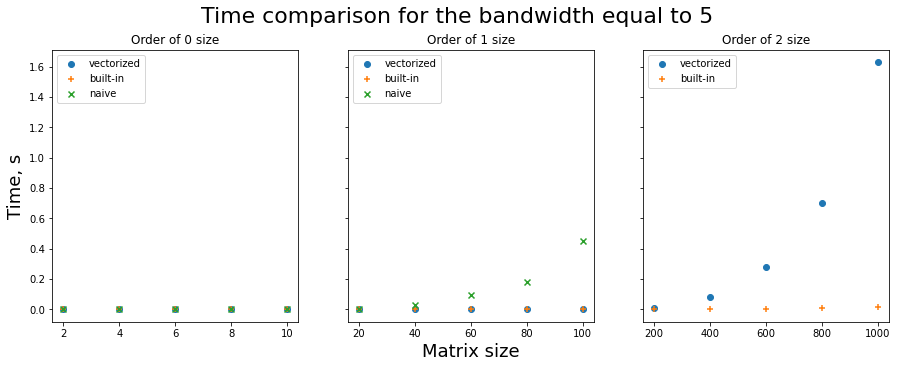

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

fig.suptitle('Time comparison for the bandwidth equal to 5', fontsize=22, y=1)


ax[0].scatter(ranges[0], vectorized[:5], label='vectorized')
ax[0].scatter(ranges[0], builtin[:5], label='built-in', marker='+')
ax[0].scatter(ranges[0], naive[:5], label='naive', marker='x')
ax[0].set_title('Order of 0 size')
ax[0].legend(loc=2)

ax[0].set_ylabel('Time, s', fontsize=18)

ax[1].scatter(ranges[1], vectorized[5:10], label='vectorized')
ax[1].scatter(ranges[1], builtin[5:10], label='built-in', marker='+')
ax[1].scatter(ranges[1], naive[5:10], label='naive', marker='x')
ax[1].set_title('Order of 1 size')
ax[1].legend(loc=2)

ax[1].set_xlabel('Matrix size', fontsize=18)

ax[2].scatter(ranges[2], vectorized[-5:], label='vectorized')
ax[2].scatter(ranges[2], builtin[-5:], label='built-in', marker='+')
ax[2].set_title('Order of 2 size')
ax[2].legend(loc=2)

plt.show()

- (2 pts) Discuss the obtained results and explain what other tricks are possible to accelerate computing the LU factorization. 

**Answer:** If the matrix size is small, all the approaches, perform similarly, with the increase in size, the naive approach slows down significantly, while the others perform similarly. However, on the matrices of order 2, the performance of the vectorized function also decreases in comparison to the built-in approach.

The profit from vectorization is obvious, however it's still far from highly computational effective built-in NumPy methods.

## Problem 2 (eigenvalues)  55 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

In [14]:
# Your solution is here

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$.

($\Rightarrow$) 

By definition of the Hermitian matrix $A = A^*$

Consider $v$, such that $Av = \lambda v$. 

On the one hand: $\left<Av, v\right> = (Av)^*v = (\lambda v)^*v = \lambda^* ||v||^2$

On the other: $\left<Av, v\right> = (Av)^*v = v^*A^*v = v^*Av = v^* \lambda v = \lambda ||v||^2$

It means that $\lambda^* = \lambda$, so that it's real.

($\Leftarrow$)

As far as $A$ is normal, it can be represented in a form $A = V \Lambda V^{-1}$, where $V$ is the unitary matrix of eigenvectors and $\Lambda$ is the diagonal eigenvalues matrix.

Also we know, that the eigenvalues are real, then 
$A^* = (V \Lambda V^{-1})^* = V \Lambda^* V^{-1} = V \Lambda V^{-1} = A$

So that, $A$ is Hermitian.

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

Solution:

$$ (\lambda - \mu)M_{11} - (-1)^n\varepsilon M_{n1} 
= (\lambda - \mu)^n - (-1)^n\varepsilon = 0
\Leftrightarrow
$$
$$
\Rightarrow
(\lambda - \mu)^n = \varepsilon e^{i(\pi n + 2\pi k)}
\Rightarrow
\lambda - \mu = \sqrt[n]{\varepsilon} e^{i(\pi n + 2\pi k)}
\Rightarrow
\mu = \lambda - \sqrt[n]{\varepsilon} e^{i(\pi + \frac{2\pi k}{n})}, k = \overline{0, n - 1}
$$

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [15]:
import scipy
from matplotlib import pyplot as plt

In [16]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    # enter your code here
    if scipy.sparse.issparse(G):
        A = scipy.sparse.csr_matrix(G.multiply(1 / np.sum(G, axis=0)))
    else:
        A = G * 1 / np.sum(G, axis=0)
    
    return A

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?

In [17]:
G = np.array([
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0]
]).T


A = pagerank_matrix(G)
np.linalg.eigvals(A)

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j ,  1. +0.j , -1. +0.j ])

**Answer:** The largest eigenvalue is 1 and it has multiplicity 2

* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

In [18]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    # enter your code here
    x = x0
    
    l = (A @ x).T @ x
    res = [np.linalg.norm(A @ x - l * x)]
    
    for iter_ in tqdm(range(num_iter)):
        x = A @ x
        x /= np.linalg.norm(x)
        
        l = ((A @ x).T @ x)
        res.append(np.linalg.norm(A @ x - l * x))
    
    return x, l, res

In [19]:
x, l, res = power_method(np.array([[2, -1], [-1, 2]]), np.array([[3., -1.]]).T, 20)
print(f'x        = {x.T}')
print(f'\lambda  = {l}')
print(f'residual = {res[-1]}')


x        = [[ 0.70710678 -0.70710678]]
\lambda  = [[3.]]
residual = 2.8679748476275033e-10


* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence.

In [20]:
x, l, res = power_method(A, np.random.sample(5).T, 100)

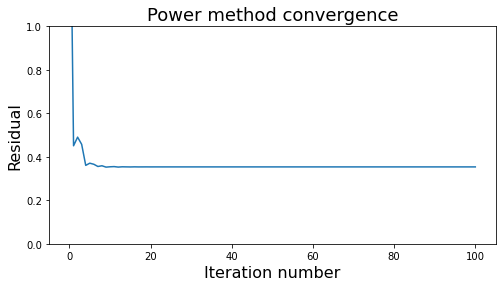

In [21]:
plt.figure(figsize=(8, 4))

plt.plot(res)

plt.title(f'Power method convergence', fontsize=18)
plt.xlabel('Iteration number', fontsize=16)
plt.ylabel('Residual', fontsize=16)

plt.ylim(0, 1)

plt.show()

**Answer:** The abscense of converrgence may be related to the fact that matrix A has two largest eigenvalues in modulus (1 and -1)

* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?

In [22]:
G = np.array([
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 1]
]).T

A = pagerank_matrix(G)
np.linalg.eigvals(A)

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j , -0.5+0.j ,  1. +0.j ])

In [23]:
x, l, res = power_method(A, np.random.sample(5).T, 100)

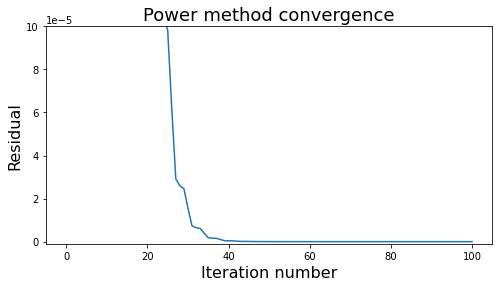

In [24]:
plt.figure(figsize=(8, 4))

plt.plot(res)

plt.title(f'Power method convergence', fontsize=18)
plt.xlabel('Iteration number', fontsize=16)
plt.ylabel('Residual', fontsize=16)

plt.ylim(-1e-6, 1e-4)

plt.show()

**Answer:** as can be seen, now there is the only one maximum eiginvalue in modulus, so the method perfectly converges

In [25]:
np.array([power_method(A, np.random.sample(5).T, 100)[0] for _ in range(10)])

array([[0.25157423, 0.50314847, 0.50314847, 0.29339177, 0.58678353],
       [0.24262509, 0.48525018, 0.48525018, 0.30665863, 0.61331726],
       [0.24401636, 0.48803271, 0.48803271, 0.30466511, 0.60933023],
       [0.29311043, 0.58622087, 0.58622087, 0.21296782, 0.42593564],
       [0.26868243, 0.53736487, 0.53736487, 0.26468387, 0.52936774],
       [0.21743014, 0.43486029, 0.43486029, 0.3389741 , 0.67794819],
       [0.29073852, 0.58147703, 0.58147703, 0.21874188, 0.43748375],
       [0.32827286, 0.65654571, 0.65654571, 0.0776304 , 0.1552608 ],
       [0.14761627, 0.29523254, 0.29523254, 0.40097006, 0.80194011],
       [0.24529969, 0.49059938, 0.49059938, 0.30280441, 0.60560882]])

**Answer:** as far as we have two distinct graph components, the algorithm may choose to adjust eigenvector to one of those parts

In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

In [26]:
N = A.shape[0]
d = .97

Ad = d * A + ((1 - d) / N) * np.ones_like(A)
np.linalg.eigvals(Ad)

array([-0.485+0.485j, -0.485-0.485j,  1.   +0.j   ,  0.97 +0.j   ,
       -0.485+0.j   ])

In [27]:
x, l, res = power_method(Ad, np.random.sample(5).T, 100)

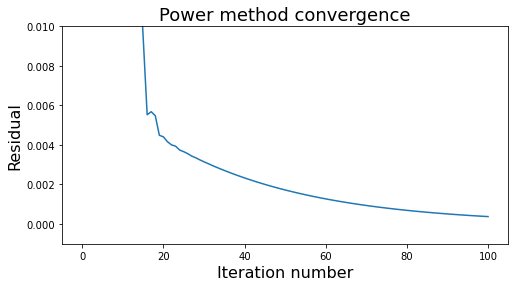

In [28]:
plt.figure(figsize=(8, 4))

plt.plot(res)

plt.title(f'Power method convergence', fontsize=18)
plt.xlabel('Iteration number', fontsize=16)
plt.ylabel('Residual', fontsize=16)

plt.ylim(-1e-3, 1e-2)

plt.show()

**Answer:** the second largest eigenvalue is equal to the dampling factor. This may occure because ...

The convergence ratio is $.97^{100} \approx .0475$

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.

* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

In [29]:
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    # enter your code here
    N = A.shape[0]
    
    Ax = np.zeros(N)
    if scipy.sparse.issparse(A):
        nnz = A.nonzero()
        np.add.at(Ax, nnz[0], np.array(A[nnz[0], nnz[1]])[0] * x[nnz[1]])
    else:
        Ax = A @ x
        
    y = Ax + ((1 - d) / N) * np.ones(N) * x.sum()
    return y

In [30]:
pagerank_matvec(scipy.sparse.random(10000, 10000, format='csr', density=1e-6), .97, np.random.sample(10000).T)

array([0.01519544, 0.01519544, 0.01519544, ..., 0.01519544, 0.01519544,
       0.01519544])

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [31]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [32]:
# Your code is here

In [33]:
# density
G.getnnz() / np.prod(G.shape)

4.4986518152305776e-05

In [34]:
# top-10 cited
authors[np.argsort(np.array(G.sum(axis=0))[0])[:-11:-1]]

array(['Scott Shenker', 'Andrew Zisserman', 'Hari Balakrishnan',
       'Jiawei Han', 'Anil K. Jain', 'Cordelia Schmid', 'Jitendra Malik',
       'Ion Stoica', 'David E. Culler', 'David G. Lowe'], dtype='<U98')

In [35]:
# set all weights to one
G[G.nonzero()] = 1

In [36]:
# calculate PageRank matrix
A = pagerank_matrix(G.T)

<ipython-input-16-5455c65c86ea>:6: RuntimeWarning: divide by zero encountered in true_divide
  A = scipy.sparse.csr_matrix(G.multiply(1 / np.sum(G, axis=0)))


In [37]:
from scipy.sparse import linalg

d = .85
L = linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))

In [38]:
x, l, res = power_method(L, np.random.sample(A.shape[0]).T, 10)

In [39]:
l

1.1103751537167434

In [40]:
authors[np.argsort(x)[:-11:-1]]

array(['David E. Goldberg', 'Richard M. Karp', 'Azriel Rosenfeld',
       'John E. Hopcroft', 'Ronald L. Rivest', 'Anil K. Jain',
       'Takeo Kanade', 'Alfred V. Aho', 'Robert Endre Tarjan',
       'Gerard Salton'], dtype='<U98')

The obtained list differs from the obtained directly from G

### 3. QR algorithm (10 pts)

* Implement QR-algorithm without shifting. Prototype of the function is given below (3 pts)

In [41]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    # enter your code here
    convergence = []
    
    A_k = A_init
    for _ in range(num_iter):
        Q, R = np.linalg.qr(A_k)
        A_k = R @ Q
        convergence.append(np.max(abs(np.tril(A_k, -1))))
        
    return A_k, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [42]:
# Your solution is here

In [43]:
n = 11
A = diags(list(map(lambda x: [x[0]] * x[1], zip([-1, 2, -1], [n - 1, n, n - 1]))), [-1, 0, 1]).toarray()

In [44]:
num_iter = 400
A_k, convergence = qr_algorithm(A, num_iter)

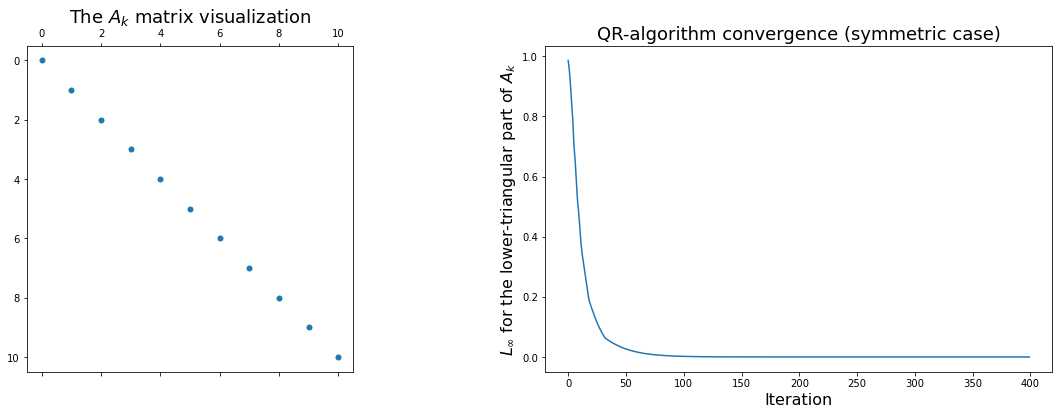

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].spy(A_k, precision=1e-7, marker='.')
ax[0].set_title('The $A_k$ matrix visualization', fontsize=18)

ax[1].plot(convergence)
ax[1].set_title('QR-algorithm convergence (symmetric case)', fontsize=18)
ax[1].set_xlabel('Iteration', fontsize=16)
ax[1].set_ylabel('$L_{\infty}$ for the lower-triangular part of $A_k$', fontsize=16)

plt.show()

#### Nonsymmetric case (4 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

In [46]:
# Your solution is here

In [47]:
n = 11
A = diags(list(map(lambda x: [x[0]] * x[1], zip([5, 3, -2], [n - 1, n, n - 1]))), [-1, 0, 1]).toarray()

In [48]:
num_iter = 250
A_k, convergence = qr_algorithm(A, num_iter)

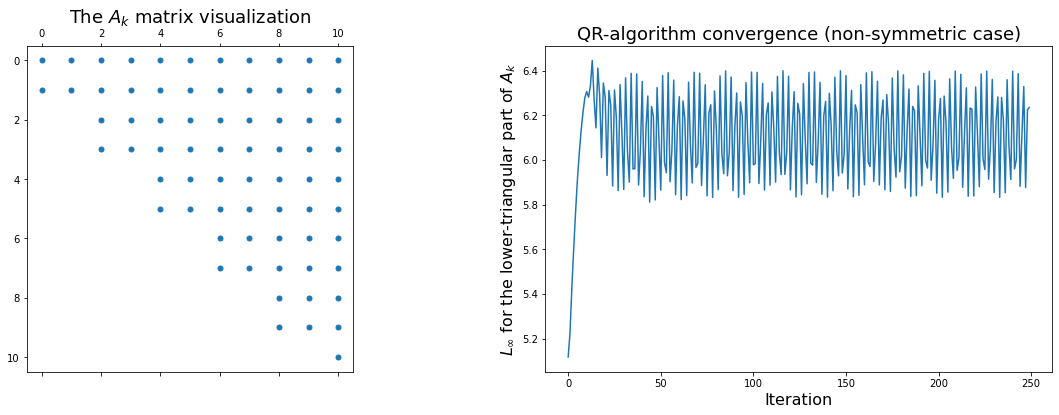

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].spy(A_k, precision=1e-7, marker='.')
ax[0].set_title('The $A_k$ matrix visualization', fontsize=18)

ax[1].plot(convergence)
ax[1].set_title('QR-algorithm convergence (non-symmetric case)', fontsize=18)
ax[1].set_xlabel('Iteration', fontsize=16)
ax[1].set_ylabel('$L_{\infty}$ for the lower-triangular part of $A_k$', fontsize=16)

plt.show()

In [50]:
np.linalg.eigvals(A_k)

array([3.+6.10905132j, 3.-6.10905132j, 3.+5.47722558j, 3.-5.47722558j,
       3.+4.47213595j, 3.-4.47213595j, 3.+3.16227766j, 3.-3.16227766j,
       3.+1.63691537j, 3.-1.63691537j, 3.+0.j        ])

In [51]:
# their modulus
print(list(map(lambda x: round(np.linalg.norm(x), 3), np.linalg.eigvals(A_k))))

[6.806, 6.806, 6.245, 6.245, 5.385, 5.385, 4.359, 4.359, 3.418, 3.418, 3.0]


**Answer:** as can be seen from the matrix structure, the $A_k$ didn't reach the desired upper-triangular format and the convergence plot gives negative prognosis for this event. The abscense of convergence may come from the fact that there are two different eigenvalues, equal in modulus.

## Problem 3. (Pseudo-Schur decomposition) 15 pts
Let's redefine scalar product $ \forall x, y \in \mathbb{C}^n$ in a following way:

$$ [x,y]_J = y^{*}Jx, \text{s.t.}\ J = \text{diag}(j_{11}, j_{22}, \dots, j_{nn})\ \text{and}\ j_{ii} = \pm1\ \forall i \in [1,n].$$

Denote rows of matrix $V \in \mathbb{C}^{n \times n}$ as $v_1, v_2, \dots, v_n$. Then $V$ is called $\textbf{J-orthonormal}$ iff 

$$[v_i, v_k]_J = \pm \delta_{ik}.$$

We will call matrix $T \in \mathbb{C}^{n \times n}$ $\textbf{almost triangular}$ iff $T$ is upper triangular with diagonal blocks of order $1$ or $2$.

Matrix $A \in \mathbb{C}^{n \times n}$ is said to be $\textbf{J-decomposable}$ if exist J-orthonormal matrix $V$ and upper triangular matrix $T$ such that 


$$A = V T V^{-1}.$$

Matrix $A \in \mathbb{C}^{n \times n}$ is said to have $\textbf{pseudoschur J-decomposition}$ if exist J-orthonormal matrix $V$ and almost triangular matrix $T$ such that


$$A = V T V^{-1}.$$

This problem is to get familiar with the fact that two abovementioned decompositions exist not for any square matrix with complex entries.




- (2 pts) $A$ has pseudoschur J-decomposition $A = V T V^{-1}, \ \text{where}\ V = \begin{bmatrix} v_1 & v_2 &  \ldots & v_n \end{bmatrix}, \ T = \begin{bmatrix} T_{ij} \end{bmatrix}$ and $v_1$ is $\textbf{not}$ an eigenvector of $A$. Show that $T_{21} \ne 0$. 



- (5 pts) Given $J = \text{diag}(1, -1)$ and $A = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix}$, prove that $A$ is not J-decomposable.


- (8 pts) Given that $A \in \mathbb{C}^{n \times n}$ is diagonalizable, show that it has pseudoschur J-decomposition for any $J$ of form $J=\text{diag}(\pm 1, \dots, \pm 1)$.
Note that in order to solve that subproblem you should firstly prove the following fact:

    Let $S \in \mathbb{C}^{m \times n},\ m \ge n,\ J = \text{diag}(\pm 1).$ If $A = S^{*}JS$ and $det(A) \ne 0$, then exists QR decomposition of $S$ with respect to $J$: 
    $$S = P_1 QR P_2^{*} = P_1 Q \begin{bmatrix} R_1 \\ 0 \end{bmatrix} P_2^{*}, \ Q^{*} J^{'}Q = J^{'}, \ J^{'} = P_1^{*}JP_1,$$ where $P_1$ and $P_2$ are permutation matrices, $Q$ is called $J^{'}$- unitary and $R_1$ is almost triangular.


In [52]:
# Your solutuion is here

- (2 pts) $A$ has pseudoschur J-decomposition $A = V T V^{-1}, \ \text{where}\ V = \begin{bmatrix} v_1 & v_2 &  \ldots & v_n \end{bmatrix}, \ T = \begin{bmatrix} T_{ij} \end{bmatrix}$ and $v_1$ is $\textbf{not}$ an eigenvector of $A$. Show that $T_{21} \ne 0$.

$T = V^{-1}AV = V^*AV =  \begin{bmatrix} v_1^* \\ \vdots \\ v_n^* \end{bmatrix} 
                         \begin{bmatrix} Av_1 & \dots & Av_n \end{bmatrix}
   = \begin{bmatrix} v_1^*Av_1 & \dots \\ v_2^*Av_1 & \dots \\ \vdots & \ddots \\ v_n^*Av_1 & \dots \end{bmatrix}$
   
The only possibility to have $\alpha e_1$ vector in the first column is $v_1$ to be the eigenvector of $A$, which is prohibited. So that, $T_{21} \neq 0$.

- (5 pts) Given $J = \text{diag}(1, -1)$ and $A = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix}$, prove that $A$ is not J-decomposable.

Let's try to construct it. The matrix T will look as follows 
$T = \begin{bmatrix} T_{11} & T_{12} \\ 0 & T_{22} \end{bmatrix}$ as far as it shoutl be upper-triangular.

So that, from the previous problem we have that $v_1$ is an eigenvector of $A$ then, 
$v_1 = \begin{bmatrix} + \frac{1}{\sqrt{2}} \\ \pm \frac{1}{\sqrt{2}} \end{bmatrix}$. 
The $J$-orthigonal to it will be the vector $v_2 = \begin{bmatrix} + \frac{1}{\sqrt{2}} \\ \pm \frac{1}{\sqrt{2}} \end{bmatrix}$. 
But this means, that the matrix $V$ is singular and has no inverse, so the decomposition does not exist.

## Problem 4. (Skeleton decomposition) 28 pts

The application that we are particularly interested in is
the approximation of a given matrix by a low-rank matrix:

$$ A \approx UV^T, A \in \mathbb{R}^{m \times n}, U \in \mathbb{R}^{m \times r}, V \in \mathbb{R}^{n \times r}.$$

It is well known that the best (in any unitary invariant norm) low-rank approximation can be computed via singular value decomposition (SVD). As an alternative, we can consider skeleton decompostion of the form:

$$A \approx A_r = A(: , \mathcal{J})A(\mathcal{I} , \mathcal{J})^{-1}A(\mathcal{I} , :),$$
where $\mathcal{I,J}$ are some index sets of length $r$.

Below we consider the matrix $N \times N$ derived from the following function discretization in the uniform grid in square $[0, 1] \times [0, 1]$:
$ f(x, y) = \exp(-\sqrt{x^2 + y^2})$.
It means that $A = [a_{ij}]$, where $a_{ij} = f(x_i, x_j)$ and $x_i = i / (N-1)$, $x_j = j / (N-1)$, where $i, j = 0,\ldots, N-1$.

- (2 pts) compose this matrix for $N = 5000$ without loops (Hint: function ```np.meshgrid``` can help you)


In [53]:
# Your solution is here

In [54]:
def f(x, y):
    return np.exp(-np.sqrt(x ** 2 + y ** 2))

N = 5000
A = f(*np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N)))

A[:3, :3]

array([[1.        , 0.99979998, 0.9996    ],
       [0.99979998, 0.99971714, 0.9995528 ],
       [0.9996    , 0.9995528 , 0.99943436]])

- (3 pts) Compute Skeleton approximation with random selection of rows and columns indices for $r = 5$ (check that submatrix in the intersection of rows and columns is nonsingular). Average the relative error $\frac{\|A - A_r \|_F}{\|A\|_F}$ over $M$ samples of column/row indices. Check that $M$ is sufficiently large to provide stable mean.

 Note: extracting submatrices should be done according to ```numpy```  e.g. ```A[index_set, :]``` to extract selected rows, ```A[:, index_set]``` to extract selected columns etc..


In [55]:
# Your solution is here

In [56]:
M = 250
r = 5

errors, mean_error_rand = [], []

pbar = tqdm(total = len(errors)+1)
while(len(errors) != M):
    iset, jset = np.random.choice(np.arange(0, N), r, False), np.random.choice(np.arange(0, N), r, False) 
    
    if np.linalg.matrix_rank(A[iset, :][:, jset], tol=1e-5) != r:
        continue
        
    Ar = A[:, jset] @ np.linalg.inv(A[iset, :][:, jset])  @ A[iset, :]
    
    error = np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro')
    errors.append(error)
    mean_error_rand.append(np.array(errors).mean())
    
    pbar.update(1)
pbar.close()

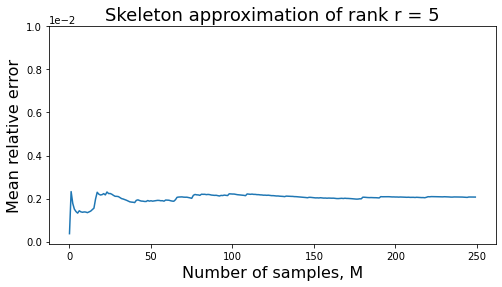

In [57]:
plt.figure(figsize=(8, 4))

plt.plot(mean_error_rand)

plt.title(f'Skeleton approximation of rank r = {r}', fontsize=18)
plt.xlabel('Number of samples, M', fontsize=16)
plt.ylabel('Mean relative error', fontsize=16)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(-1e-4, 1e-2)

plt.show()

As you should know from the lecture, if $A$ is of rank $r$ and $\hat{A} = A(\mathcal{I} , \mathcal{J})$ is nonsingular, then the exact equality holds. In the approximate case, however, the quality of the approximation depends on the volume of the submatrix $\hat{A}$: 

**Theorem**

*If $\hat{A} = A_{max}$ has maximal in modulus determinant among all $r \times r$ submatrices of $A$, the following error etimate holds:*

$$ \|A - A_r\|_1 \leq (r+1)\sigma_{r+1}.$$


And the question is how to choose a good submatrix of nearly maximal volume in practice.

**Definition**: *We call $r \times r$ submatrix $A_{dom}$ of rectangular $n \times r$ matrix $A$ of
full rank dominant, if all the entries of $AA_{dom}^{-1}$ are not greater than $1$ in
modulus.*

The crucial theoretical result behind the scene is that the volume of any dominant submatrix $A_{dom}$ can not be very much smaller than the maximum volume submatrix $A_{max}$ (without proof).

We provide the following algorithm for constructing dominant submatrix of a tall matrix.

**Algorithm 1**: 
    
Given matrix $A$ of size $n \times r$ finds dominant submatrix of size $r \times r$

__step 0.__ Start with arbitrary nonsingular $r \times r$ submatrix $A_{dom}$. Reorder rows in $A$ so that $A_{dom}$ occupies first $r$ rows in $A$.

__step 1.__ Compute $B = AA_{dom}^{-1}$ and find its maximum in module  entry $b_{ij}$.

__step 2.__ **If $|b_{ij}| > 1 + \delta$, then**:

Swap rows $i$ and $j$ in $B$ (accrodignly in A). By swapping the rows we have increased the volume of the upper submatrix in $B$, as well as in $A$ (why?). Let $A_{dom}$ be the new upper submatrix of $A$ and go to __step 1__.

**elseif $|b_{ij}| < 1 + \delta$**:

return $A_{dom}$.

Note: $\delta = 10^{-2}$ seems to be a good practical choice.

- (10 pts) Implement algorithm 1 according to the following signature, where the function returns ```row_indices``` array which can be used as ```A[row_indices, :]``` to extract selected submatrix.

Note that matrix inverse $A_{dom}^{-1}$ in step 3 has to be updated efficiently using [Shermann-Morison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) (inverse of rank-1 update).

In [58]:
def sm_inv(Adom_1, u, v):
    return Adom_1 - (Adom_1 @ u @ v.T @ Adom_1) / (1. + v.T @ Adom_1 @ u)

def dominant_submatrix_search(A, d=1e-2):
    # Your code is here
    n, r = A.shape
    
    row_indices = np.random.permutation(np.arange(n))
    A = A[row_indices, :]
    
    assert np.linalg.matrix_rank(A[:r, :], tol=1e-5) == r, np.linalg.matrix_rank(A[:r, :], tol=1e-5)
    
    Adom_1 = np.linalg.inv(A[:r, :])
    B = A @ Adom_1

    while(abs(B).max() > 1 + d):
        i, j = np.unravel_index(np.argmax(abs(B)), B.shape)
        
        u, v = (np.eye(n)[[j]] - np.eye(n)[[i]])[:, :r].T, (A[[i], :] - A[[j], :]).T
        
        A[[i, j], :] = A[[j, i], :]
        B[[i, j], :] = B[[j, i], :]
        row_indices[[i, j]] = row_indices[[j, i]]
        
        Adom_1 = sm_inv(Adom_1, u, v)  
        B = A @ Adom_1
 
    return row_indices[:r]

In [59]:
# check the convergence of your implementation on random data
row_indices = dominant_submatrix_search(np.random.rand(5000, 10))

- (10 pts) Propose the method to construct Skeleton approximation using Algorithm 1. The signature of the function is provided below.  Compare your algorithm with previously considered random selection on the matrix $A$.

Hint: 

1) start with random selection of columns 

2) if you transpose the matrix for which you find rows, then Algorithm 1 will give you update for columns in the initial matrix

In [60]:
def skeleton(A, r):
    # Your code is here
    column_indices = np.random.choice(np.arange(0, N), r, False)
    
    row_indices = dominant_submatrix_search(A[:, column_indices].copy(), d=1e-2)
    column_indices = dominant_submatrix_search(A[row_indices, :].T.copy(), d=1e-2)
    
    return row_indices, column_indices

In [61]:
M = 250
r = 5

errors, mean_error_dom = [], []

pbar = tqdm(total = len(errors)+1)
while(len(errors) != M):
    try:
        iset, jset = skeleton(A, r) 
    except AssertionError:
        continue
        
    if np.linalg.matrix_rank(A[iset, :][:, jset], tol=1e-5) != r:
        continue
        
    Ar = A[:, jset] @ np.linalg.inv(A[iset, :][:, jset]) @ A[iset, :]
    
    error = np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro')
    errors.append(error)
    mean_error_dom.append(np.array(errors).mean())
    
    pbar.update(1)
pbar.close()

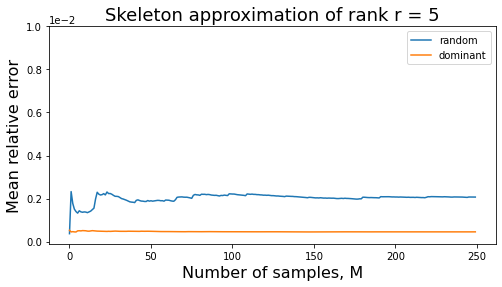

In [62]:
plt.figure(figsize=(8, 4))

plt.plot(mean_error_rand, label='random')
plt.plot(mean_error_dom, label='dominant')

plt.legend(loc='best')

plt.title(f'Skeleton approximation of rank r = {r}', fontsize=18)
plt.xlabel('Number of samples, M', fontsize=16)
plt.ylabel('Mean relative error', fontsize=16)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(-1e-4, 1e-2)

plt.show()

**Answer:** the dominant approach dominates the random one

- (3 pts) Compare your ```skeleton``` approximation algorithm with SVD and discuss its pros and cons.

In [63]:
# Your solution is here

In [64]:
%%time
u, s, v = np.linalg.svd(A)

CPU times: user 2min 53s, sys: 1e+03 ms, total: 2min 54s
Wall time: 44 s


In [65]:
error_svd = np.linalg.norm(A - u[:, :r] @ np.diag(s[:r]) @ v[:r, :], ord='fro') / np.linalg.norm(A, ord='fro')
np.round(error_svd, 5)

0.00012

In [116]:
%%time
iset, jset = skeleton(A, r)

CPU times: user 364 ms, sys: 110 ms, total: 475 ms
Wall time: 120 ms


In [118]:
Ar = A[:, jset] @ np.linalg.inv(A[iset, :][:, jset]) @ A[iset, :]
np.round(np.linalg.norm(A - Ar, ord='fro') / np.linalg.norm(A, ord='fro'), 5)

0.00057

**Answer:** there is a tradeoff between the SVD accuracy and Skeleton speed